# Model Selection and Evaluation Workshop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/njpinton/CMSC173/blob/main/09-ModelSelection/notebooks/model_selection_workshop.ipynb)

## Learning Objectives

By the end of this workshop, you will be able to:
- Understand and apply the bias-variance tradeoff
- Implement proper train-validation-test splitting
- Use cross-validation for model selection
- Apply regularization techniques (Ridge, Lasso, Elastic Net)
- Evaluate models using appropriate metrics
- Diagnose overfitting and underfitting

**Estimated Time:** 45-60 minutes

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_classification, load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## Part 1: Understanding the Bias-Variance Tradeoff

Let's explore how model complexity affects bias and variance through a hands-on example.

In [2]:
# Generate synthetic data
def generate_data(n_samples=100, noise=0.5):
    X = np.linspace(0, 10, n_samples)
    y_true = np.sin(X) + 0.5 * X
    y = y_true + np.random.normal(0, noise, n_samples)
    return X.reshape(-1, 1), y, y_true

X, y, y_true = generate_data(n_samples=50, noise=1.5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 35
Test samples: 15


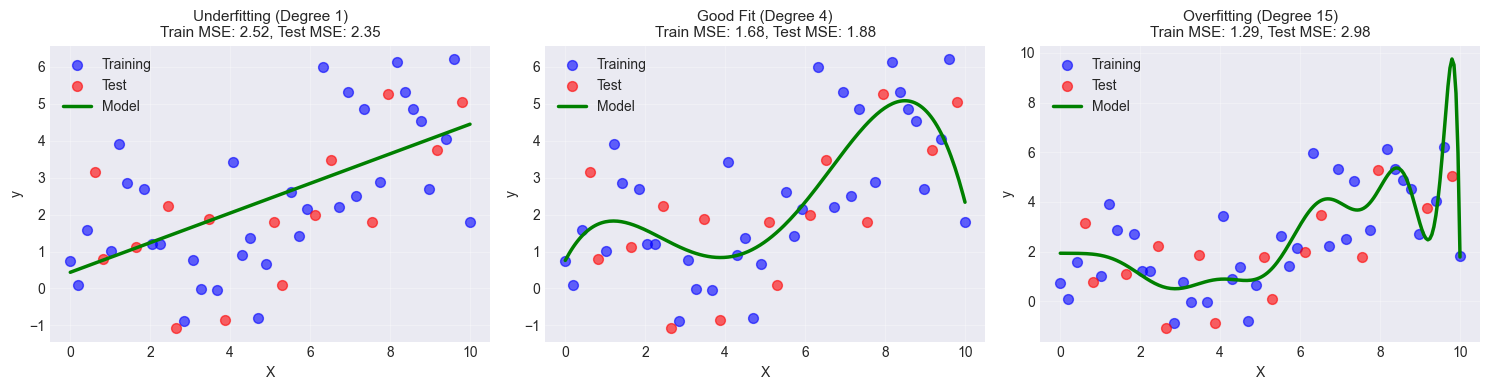

In [3]:
# Compare different polynomial degrees
degrees = [1, 4, 15]
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ['Underfitting (Degree 1)', 'Good Fit (Degree 4)', 'Overfitting (Degree 15)']

for ax, degree, title in zip(axes, degrees, titles):
    # Fit polynomial model
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_plot_poly = poly.transform(X_plot)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot_pred = model.predict(X_plot_poly)
    
    # Compute errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Plot
    ax.scatter(X_train, y_train, c='blue', s=50, alpha=0.6, label='Training')
    ax.scatter(X_test, y_test, c='red', s=50, alpha=0.6, label='Test')
    ax.plot(X_plot, y_plot_pred, 'g-', linewidth=2.5, label=f'Model')
    
    ax.set_title(f'{title}\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}', fontsize=11)
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations

- **Degree 1 (Underfitting):** Both training and test errors are high. The model is too simple.
- **Degree 4 (Good Fit):** Both errors are low and similar. The model captures the pattern well.
- **Degree 15 (Overfitting):** Training error is very low, but test error is high. The model memorizes noise.

## Part 2: Model Complexity and Validation Curves

Let's systematically evaluate different model complexities.

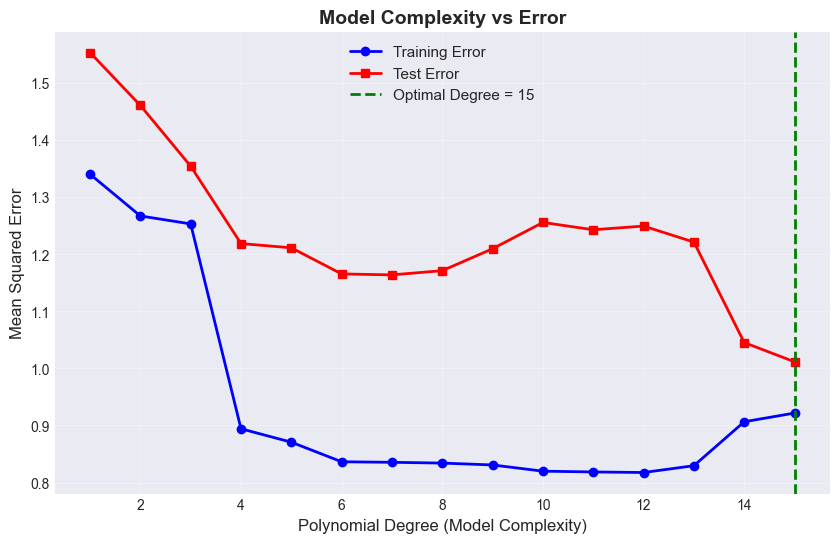


Optimal polynomial degree: 15
Test MSE at optimal degree: 1.01


In [4]:
# Generate larger dataset
X, y, _ = generate_data(n_samples=200, noise=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test different polynomial degrees
max_degree = 15
degrees = range(1, max_degree + 1)
train_errors = []
test_errors = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, 'b-o', linewidth=2, label='Training Error', markersize=6)
plt.plot(degrees, test_errors, 'r-s', linewidth=2, label='Test Error', markersize=6)

optimal_degree = degrees[np.argmin(test_errors)]
plt.axvline(optimal_degree, color='green', linestyle='--', linewidth=2, 
            label=f'Optimal Degree = {optimal_degree}')

plt.xlabel('Polynomial Degree (Model Complexity)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Model Complexity vs Error', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nOptimal polynomial degree: {optimal_degree}")
print(f"Test MSE at optimal degree: {min(test_errors):.2f}")

## Part 3: Cross-Validation for Robust Estimation

Single train-test splits can be unreliable. Let's use cross-validation for better estimates.

Cross-Validation Results (Degree 4):
  Fold scores: [1.02414349 1.26906487 1.02233514 0.99974594 0.76564791]
  Mean MSE: 1.016 (+/- 0.159)


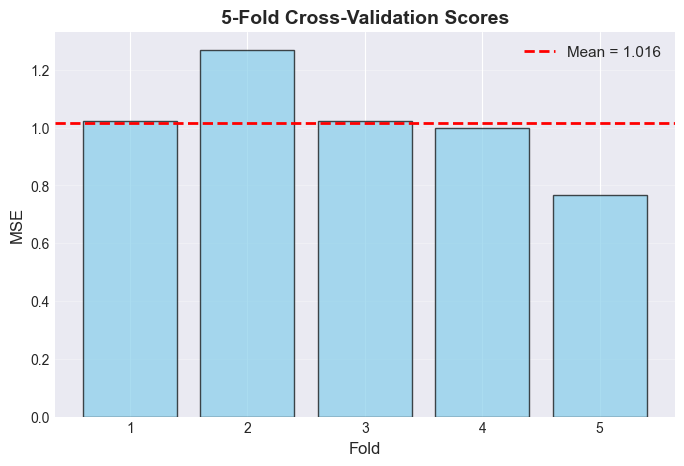

In [5]:
from sklearn.model_selection import KFold

# Generate data
X, y, _ = generate_data(n_samples=200, noise=1.0)

# Test polynomial degree 4 with 5-fold CV
degree = 4
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_poly, y, cv=kfold, 
                            scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert to positive MSE

print(f"Cross-Validation Results (Degree {degree}):")
print(f"  Fold scores: {cv_scores}")
print(f"  Mean MSE: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Visualize CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {cv_scores.mean():.3f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

## Part 4: Regularization - Ridge, Lasso, and Elastic Net

Let's explore how regularization prevents overfitting.

In [6]:
# Load real dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape: {X.shape}")
print(f"Features: {diabetes.feature_names}")

Dataset shape: (442, 10)
Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


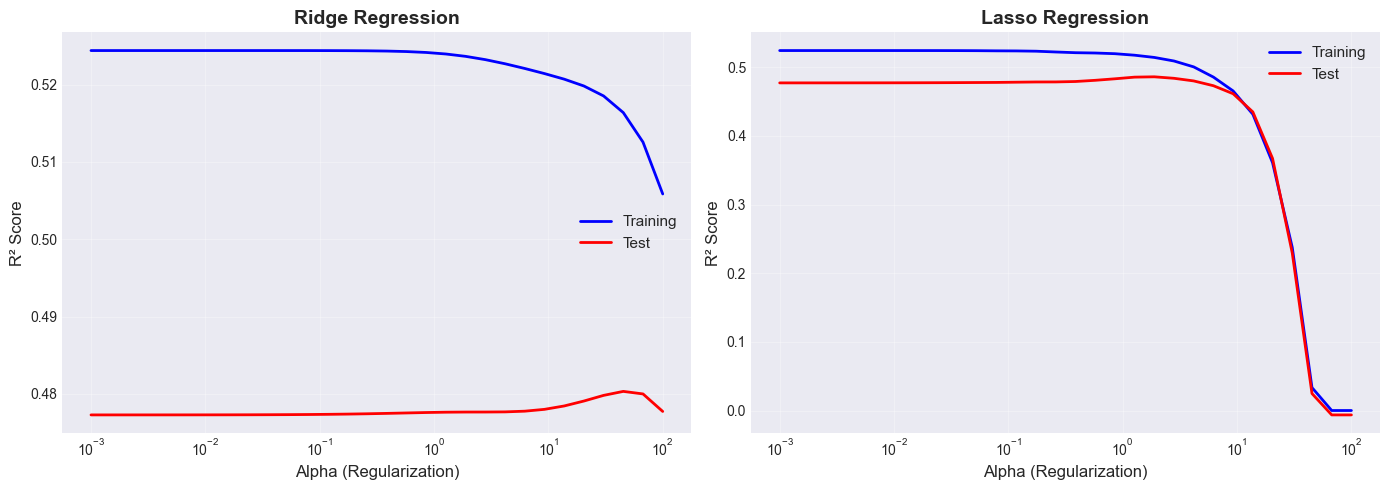


Optimal Ridge alpha: 45.2035 (R² = 0.480)
Optimal Lasso alpha: 1.8874 (R² = 0.486)


In [7]:
# Compare different regularization methods
alphas = np.logspace(-3, 2, 30)

ridge_train_scores = []
ridge_test_scores = []
lasso_train_scores = []
lasso_test_scores = []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_train_scores.append(r2_score(y_train, ridge.predict(X_train_scaled)))
    ridge_test_scores.append(r2_score(y_test, ridge.predict(X_test_scaled)))
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_train_scores.append(r2_score(y_train, lasso.predict(X_train_scaled)))
    lasso_test_scores.append(r2_score(y_test, lasso.predict(X_test_scaled)))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge
axes[0].plot(alphas, ridge_train_scores, 'b-', linewidth=2, label='Training')
axes[0].plot(alphas, ridge_test_scores, 'r-', linewidth=2, label='Test')
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (Regularization)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Ridge Regression', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Lasso
axes[1].plot(alphas, lasso_train_scores, 'b-', linewidth=2, label='Training')
axes[1].plot(alphas, lasso_test_scores, 'r-', linewidth=2, label='Test')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (Regularization)', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Lasso Regression', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal alpha
optimal_ridge_idx = np.argmax(ridge_test_scores)
optimal_lasso_idx = np.argmax(lasso_test_scores)

print(f"\nOptimal Ridge alpha: {alphas[optimal_ridge_idx]:.4f} (R² = {ridge_test_scores[optimal_ridge_idx]:.3f})")
print(f"Optimal Lasso alpha: {alphas[optimal_lasso_idx]:.4f} (R² = {lasso_test_scores[optimal_lasso_idx]:.3f})")

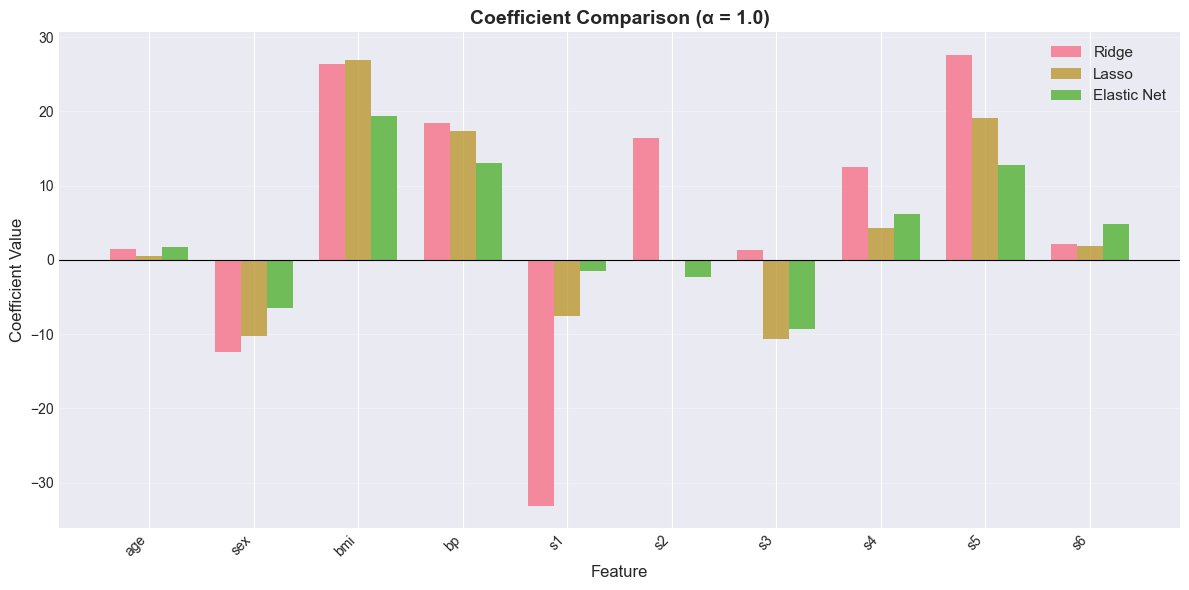


Number of non-zero coefficients:
  Ridge: 10
  Lasso: 9
  Elastic Net: 10


In [8]:
# Compare coefficient sparsity
alpha = 1.0

ridge = Ridge(alpha=alpha)
lasso = Lasso(alpha=alpha, max_iter=10000)
enet = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
enet.fit(X_train_scaled, y_train)

# Plot coefficients
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(diabetes.feature_names))
width = 0.25

ax.bar(x_pos - width, ridge.coef_, width, label='Ridge', alpha=0.8)
ax.bar(x_pos, lasso.coef_, width, label='Lasso', alpha=0.8)
ax.bar(x_pos + width, enet.coef_, width, label='Elastic Net', alpha=0.8)

ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title(f'Coefficient Comparison (α = {alpha})', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(diabetes.feature_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nNumber of non-zero coefficients:")
print(f"  Ridge: {np.sum(np.abs(ridge.coef_) > 0.01)}")
print(f"  Lasso: {np.sum(np.abs(lasso.coef_) > 0.01)}")
print(f"  Elastic Net: {np.sum(np.abs(enet.coef_) > 0.01)}")

## Part 5: Classification Metrics

Let's explore evaluation metrics for classification problems.

In [9]:
# Generate binary classification data
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=20, n_informative=15,
                           n_redundant=5, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Accuracy: 0.873


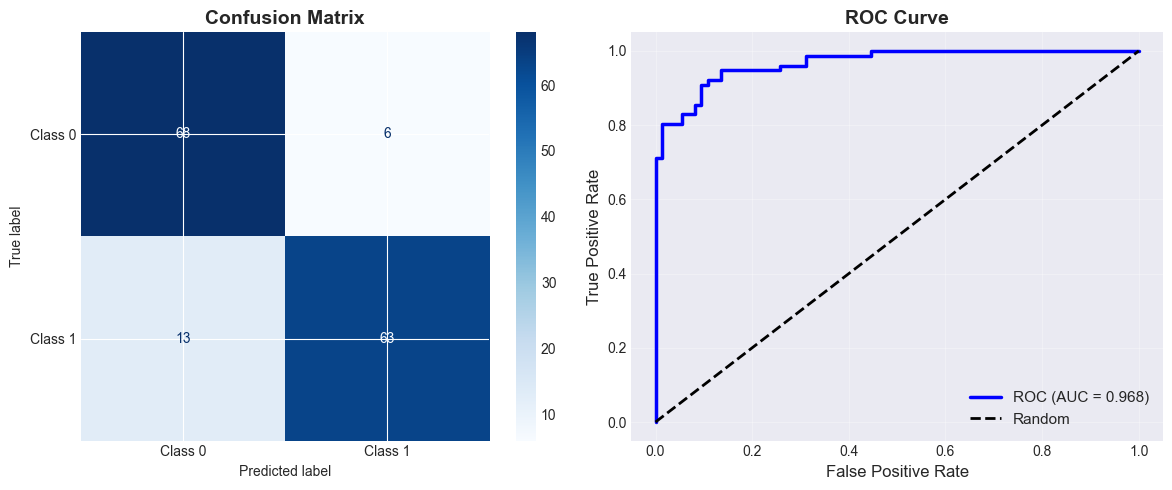


Classification Metrics:
  Precision: 0.913
  Recall: 0.829
  F1-Score: 0.869
  ROC-AUC: 0.968


In [10]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"\nClassification Metrics:")
print(f"  Precision: {precision_score(y_test, y_pred):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred):.3f}")
print(f"  F1-Score: {f1_score(y_test, y_pred):.3f}")
print(f"  ROC-AUC: {roc_auc:.3f}")

---

## Student Activity (15 minutes)

### Task: Model Selection Challenge

You are given a regression problem. Your goal is to:

1. **Load and explore the data** (provided below)
2. **Split the data** into training and test sets (70-30 split)
3. **Try different models:**
   - Linear Regression
   - Ridge Regression (try at least 3 different alpha values)
   - Lasso Regression (try at least 3 different alpha values)
4. **Use 5-fold cross-validation** to evaluate each model
5. **Select the best model** based on cross-validation scores
6. **Evaluate the best model** on the test set
7. **Report:**
   - Cross-validation scores for all models
   - The best model and its hyperparameters
   - Test set performance (MSE and R²)

### Starter Code

In [11]:
# Generate challenge dataset
np.random.seed(123)
n_samples = 300
n_features = 30

X_challenge, y_challenge = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=20,
    noise=10,
    random_state=123
)

print(f"Dataset shape: {X_challenge.shape}")
print(f"Target range: [{y_challenge.min():.2f}, {y_challenge.max():.2f}]")

# YOUR CODE HERE
# Step 1: Split the data


# Step 2: Standardize features


# Step 3: Define models to test


# Step 4: Evaluate each model with cross-validation


# Step 5: Select best model


# Step 6: Evaluate on test set


# Step 7: Report results


Dataset shape: (300, 30)
Target range: [-654.73, 805.08]


---

## Solutions (Hidden)

Cross-Validation Results:
Linear Regression         MSE:   127.31 (+/-  19.60)
Ridge (α=0.1)             MSE:   127.40 (+/-  19.97)
Ridge (α=1.0)             MSE:   131.19 (+/-  23.15)
Ridge (α=10.0)            MSE:   420.39 (+/-  91.63)
Lasso (α=0.1)             MSE:   125.85 (+/-  19.91)
Lasso (α=1.0)             MSE:   147.60 (+/-  30.55)
Lasso (α=10.0)            MSE:  2139.64 (+/- 749.44)

Best Model: Lasso (α=0.1)
CV MSE: 125.85

Test Set Performance:
  MSE: 136.84
  R²: 0.998
  RMSE: 11.70


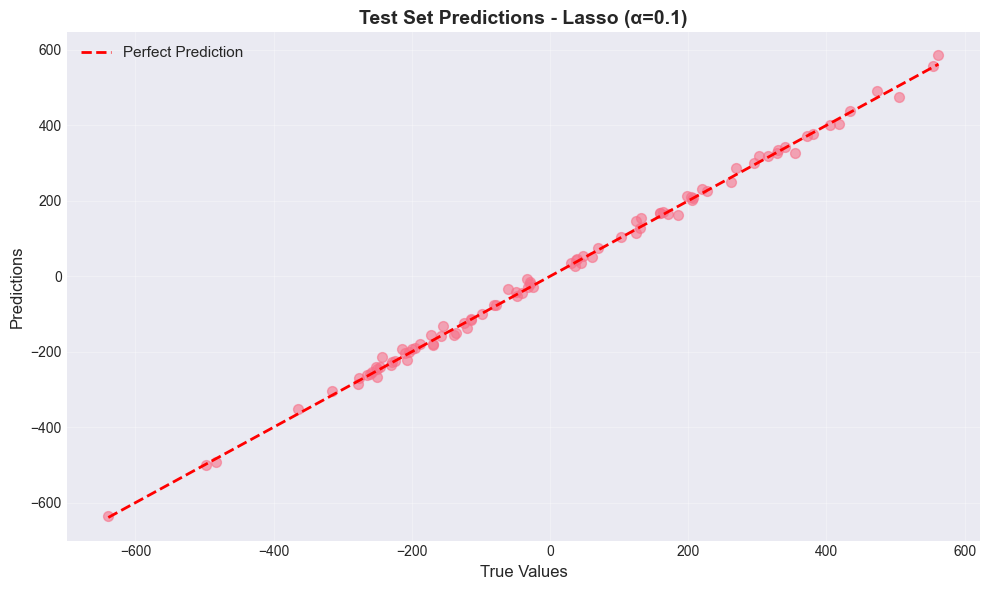

In [12]:
# SOLUTION

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_challenge, y_challenge, test_size=0.3, random_state=42
)

# Step 2: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=10000),
    'Lasso (α=1.0)': Lasso(alpha=1.0, max_iter=10000),
    'Lasso (α=10.0)': Lasso(alpha=10.0, max_iter=10000),
}

# Step 4: Evaluate each model with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("Cross-Validation Results:\n" + "="*60)
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=kfold, scoring='neg_mean_squared_error'
    )
    cv_scores = -cv_scores  # Convert to positive MSE
    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    print(f"{name:25s} MSE: {cv_scores.mean():8.2f} (+/- {cv_scores.std():6.2f})")

# Step 5: Select best model
best_model_name = min(results, key=lambda x: results[x]['cv_mean'])
best_model = results[best_model_name]['model']

print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"CV MSE: {results[best_model_name]['cv_mean']:.2f}")

# Step 6: Train best model and evaluate on test set
best_model.fit(X_train_scaled, y_train)
y_test_pred = best_model.predict(X_test_scaled)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Step 7: Report results
print(f"\nTest Set Performance:")
print(f"  MSE: {test_mse:.2f}")
print(f"  R²: {test_r2:.3f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title(f'Test Set Predictions - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### What We Learned

1. **Bias-Variance Tradeoff:**
   - Simple models have high bias, complex models have high variance
   - Optimal model balances both sources of error
   - Visualizing learning curves helps diagnose fitting issues

2. **Model Validation:**
   - Always use separate train/test sets
   - Cross-validation provides robust performance estimates
   - Never evaluate final performance on training data

3. **Regularization:**
   - Ridge (L2): shrinks coefficients, keeps all features
   - Lasso (L1): performs feature selection via sparsity
   - Elastic Net: combines benefits of both
   - Regularization strength (α) must be tuned via validation

4. **Evaluation Metrics:**
   - Regression: MSE, RMSE, MAE, R²
   - Classification: accuracy, precision, recall, F1, ROC-AUC
   - Choose metrics aligned with your problem goals

### Best Practices

- ✅ Always split data before preprocessing
- ✅ Use cross-validation for hyperparameter tuning
- ✅ Standardize features for regularization methods
- ✅ Test set is sacred - use it only once for final evaluation
- ✅ Track both training and validation performance
- ✅ Choose appropriate metrics for your problem

### Next Steps

- Practice with different datasets
- Explore nested cross-validation
- Try grid search and random search for hyperparameter tuning
- Learn about ensemble methods
- Study advanced regularization techniques